# Homework 3
## ALCF AI for Science on Supercomputers
### Zachary Marks


# Convolutional Neural Networks

Notebook by Corey Adams, some modifications by Bethany Lusch

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.

Tip: this notebook is much faster on the GPU!


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/ImageNet.png?raw=1)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [62]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [63]:
from PIL import Image
# wget line useful in Google Colab
! wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg
alcf_image = Image.open("ALCF-Staff.jpg")

--2024-11-25 23:13:23--  https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 417835 (408K) [image/jpeg]
Saving to: ‘ALCF-Staff.jpg.1’

ALCF-Staff.jpg.1    100%[===================>] 408.04K  --.-KB/s    in 0.03s   

2024-11-25 23:13:23 (12.2 MB/s) - ‘ALCF-Staff.jpg.1’ saved [417835/417835]



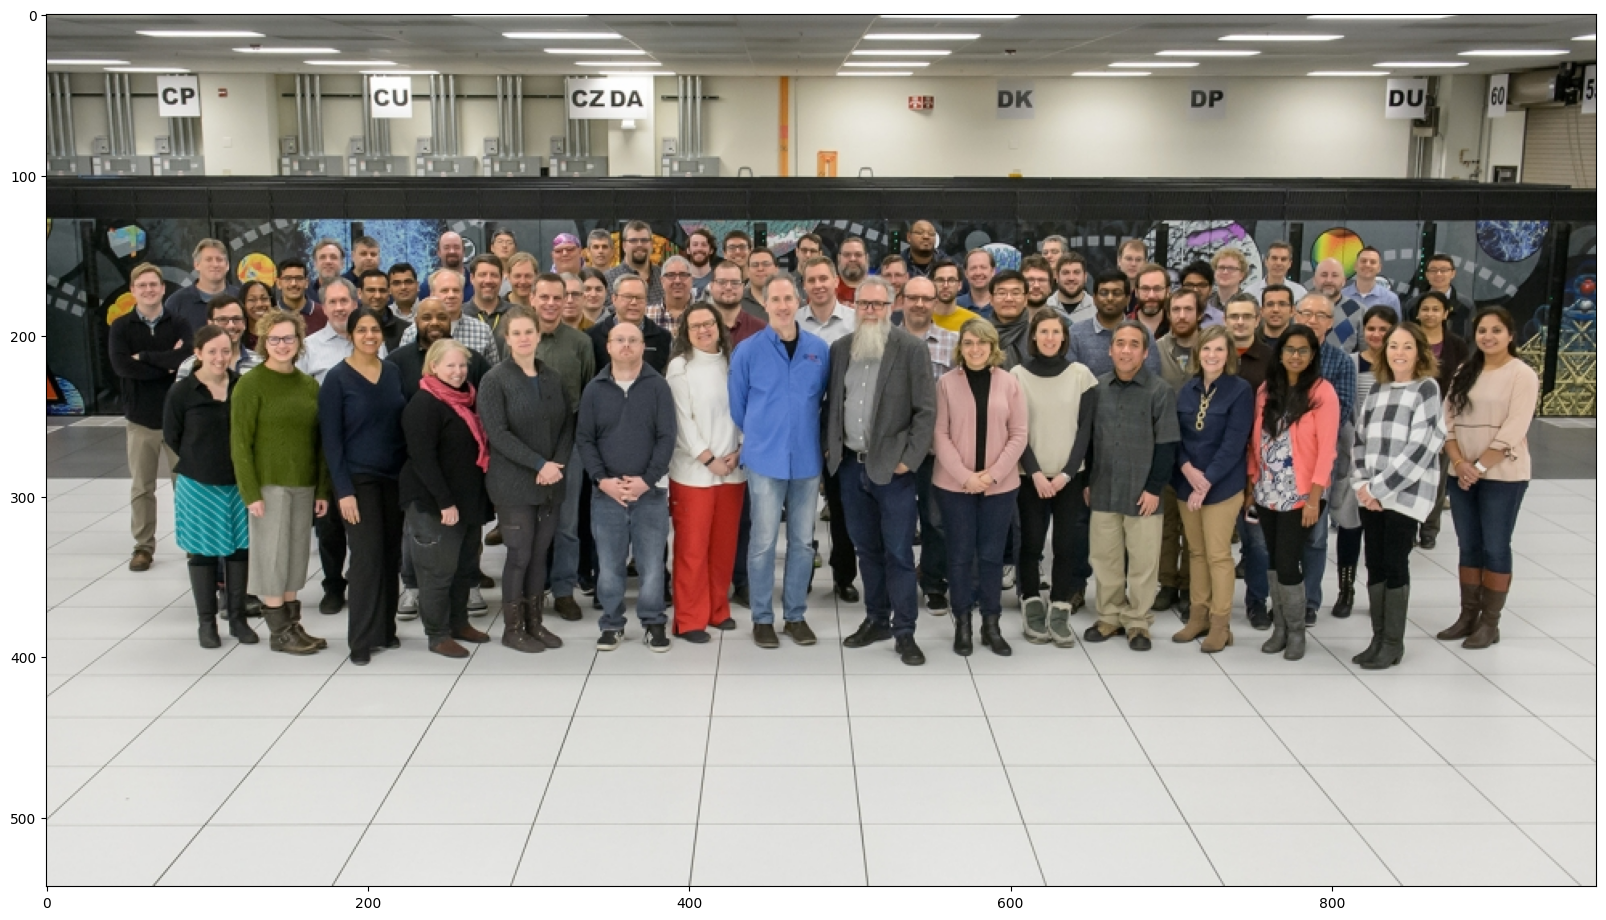

In [64]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

![image-2.png](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/conv_eqn.png?raw=1)

![image.png](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/conv.png?raw=1)


Played with code below to change from grayscale to color!

torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


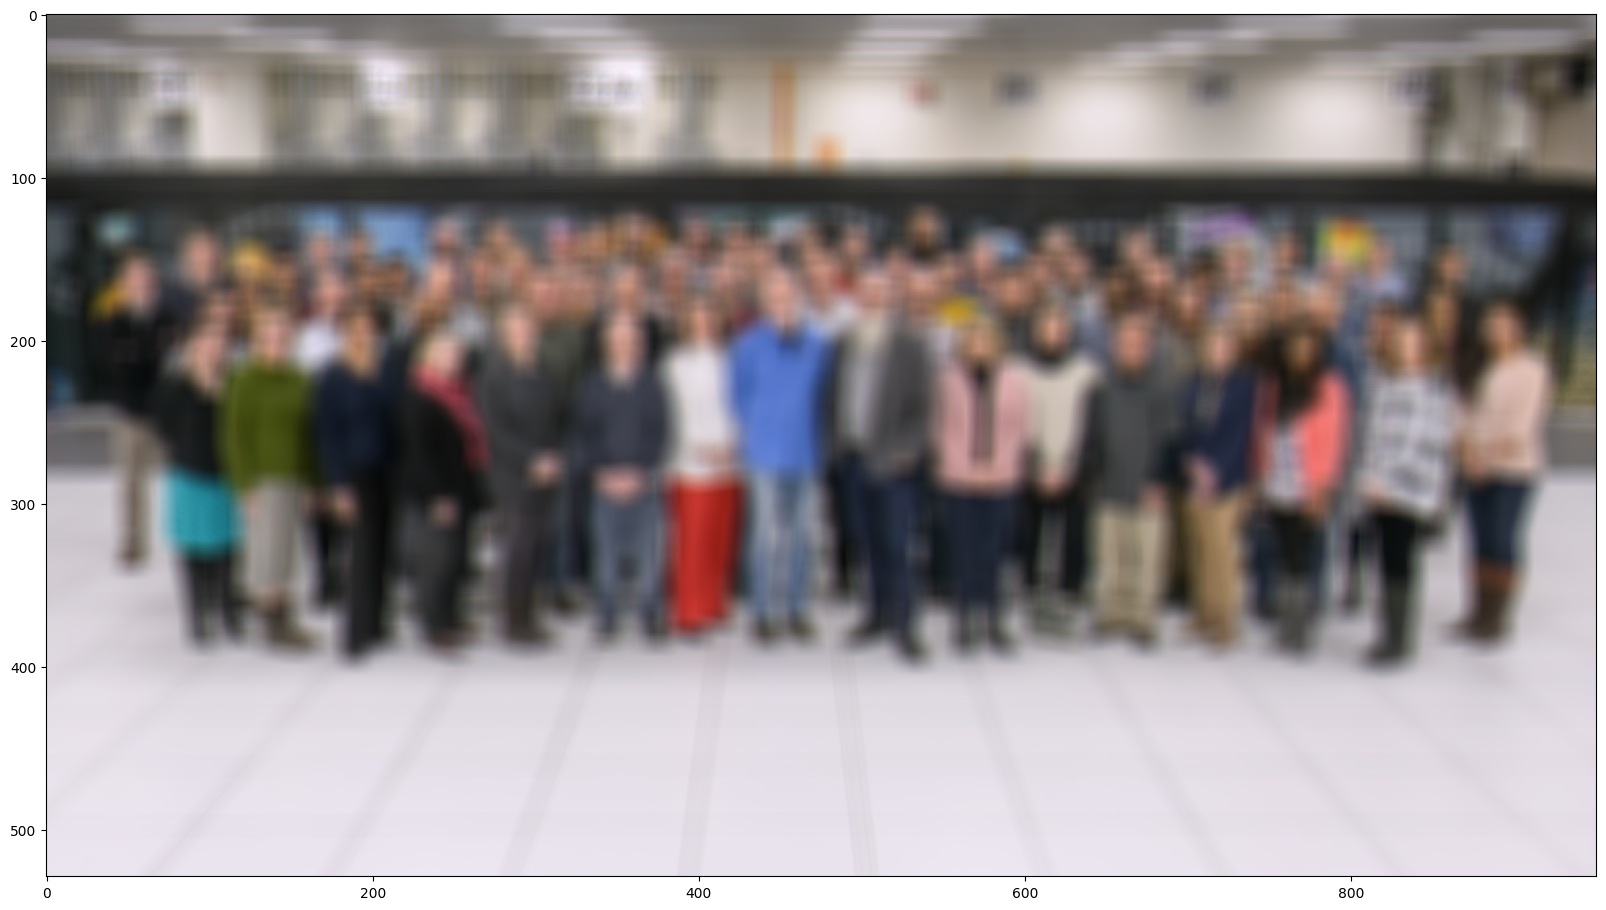

In [65]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)


# Reshape the tensor to have a batch size of 1:
# (BATCH SIZE, CHANNELS_IN, HEIGHT_IN, WEIGHT_IN) = (1, 3, H_in, W_in)
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,1,15,15))
# ORIGINAL IS conv_random = torch.rand((3,3,15,15)) --> CHANGE LINE BELOW AS WELL

#PRINT CONV FOR TENSOR VISUALIZATION
#print(conv_random)

# torch.nn.functional.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1)
alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random, groups=3)
# ORIGINAL IS alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random, groups=1) --> CHANGE LINE ABOVE AS WELL
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:]) # Reshapes to original shape, removing element 0, the batch size

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Normalization

![Batch Norm](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/batch_norm.png?raw=1)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/batch_norm_effect.png?raw=1)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


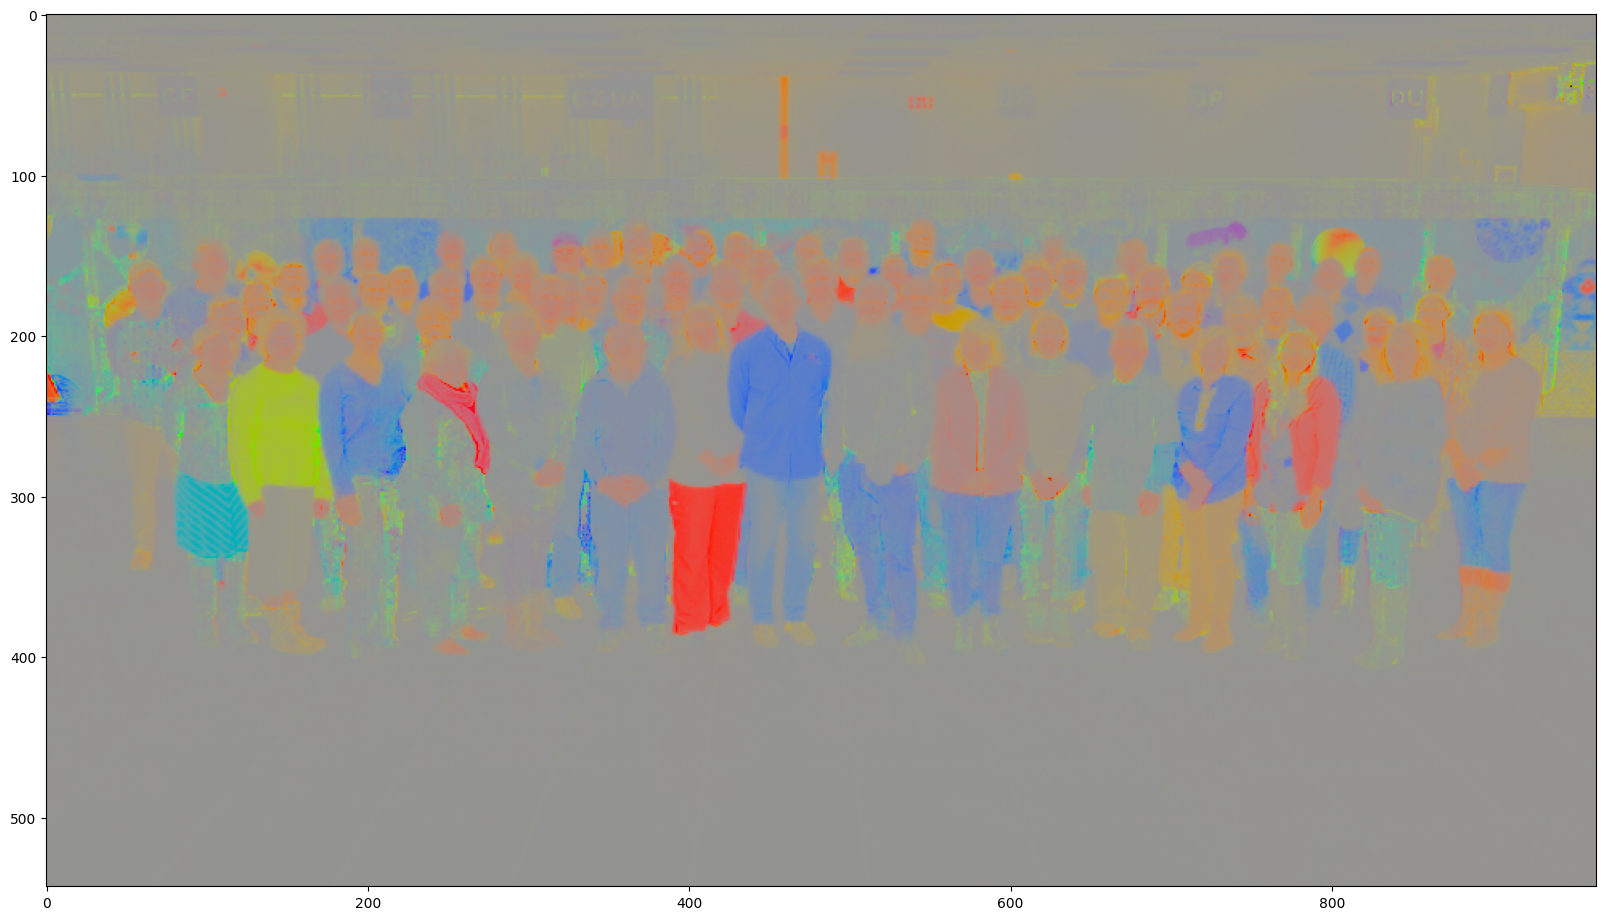

In [66]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

# MATPLOTLIB IMSHOW() USES (HEIGHT, WIDTH, CHANNELS) WHILE PYTORCH USES (CHANNELS, HEIGHT, WIDTH)
# RESHAPE USING .permute() TO USE THE ORDER THAT IMSHOW() REQUIRES
rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


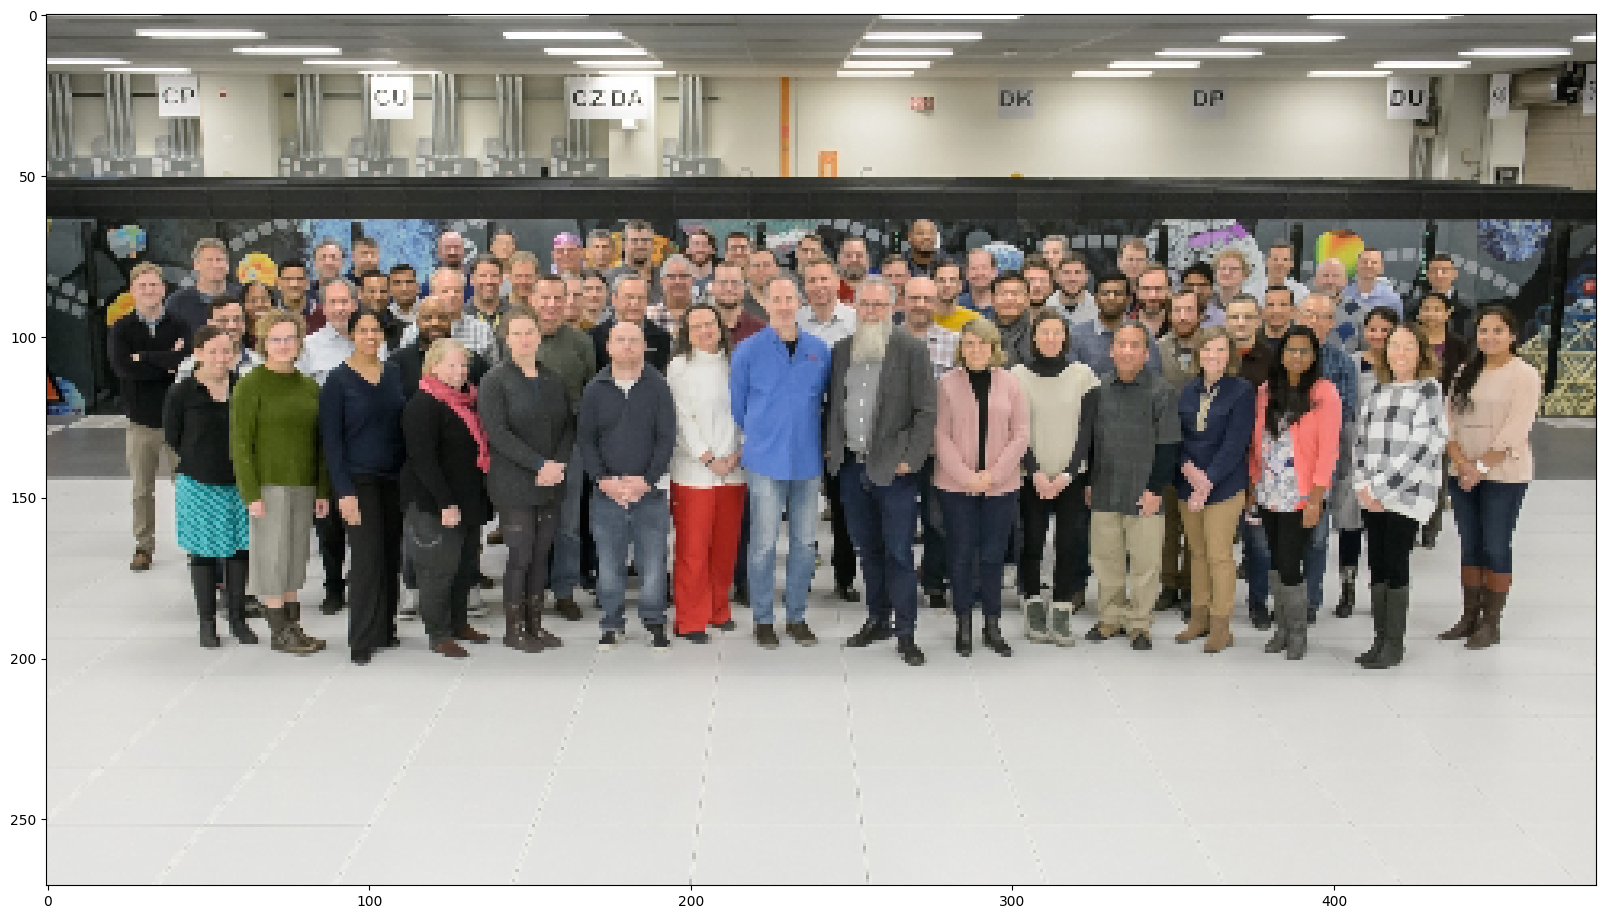

In [67]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/residual_layer.png?raw=1)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/resnet_comparison.png?raw=1)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [68]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
from matplotlib import pyplot as plt
%matplotlib inline

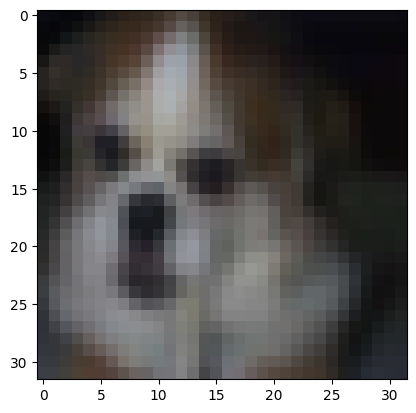

In [70]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    # -1 MEANS FINAL INPUT IN ARRAY, SO IT IS USED AS A PLACEHOLDER TO ALWAYS MEAN THE NUMBER OF EXAMPLES IN THE BATCH - IN THIS CASE, 128
    # 32 x 32 PIXEL IMAGE
    # STORES THE X (EXAMPLES) IN THE DEVICE (GPU IF DETECTED ABOVE) AND THE LABELS (Y) ALSO IN THE DEVICE
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [11]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, separable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [71]:
!pip install torchinfo # if not on Polaris

In [13]:
model = Classifier(32, 4, 2).to(device=dev)
# n_initial_filters (pixels x pixels), n_stages, blocks_per_stage
from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [14]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [15]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [17]:
%%time

from tqdm.notebook import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training & validation loss & accuracy
    # for training data - only once every 5 epochs (takes a while)
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")

    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:

        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")


Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.134, accuracy: 21.091


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.141, accuracy: 21.114


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.993, accuracy: 27.344


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.926, accuracy: 28.649


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.925, accuracy: 30.578


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.835, accuracy: 32.377


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.784, accuracy: 35.498


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.783, accuracy: 35.512


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.792, accuracy: 34.474


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.752, accuracy: 36.303


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.740, accuracy: 36.294


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.749, accuracy: 36.373


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.664, accuracy: 39.934


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.663, accuracy: 39.488


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.620, accuracy: 40.823


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.638, accuracy: 40.536


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.593, accuracy: 42.049


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.606, accuracy: 40.348


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.638, accuracy: 39.896


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.642, accuracy: 39.221


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.546, accuracy: 43.434


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.536, accuracy: 44.254


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.528, accuracy: 43.621


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.546, accuracy: 43.730


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.473, accuracy: 47.102


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.481, accuracy: 46.539


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.594, accuracy: 42.178


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.508, accuracy: 44.729


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.457, accuracy: 47.636


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.430, accuracy: 48.348


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.448, accuracy: 48.295


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.454, accuracy: 47.617


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.431, accuracy: 48.477


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.419, accuracy: 47.973


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.425, accuracy: 47.923


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.411, accuracy: 48.892
CPU times: user 4min 47s, sys: 20 s, total: 5min 7s
Wall time: 26min 32s


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [75]:
from torchvision.transforms import v2
from torchinfo import summary
training_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 64

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    # -1 MEANS FINAL INPUT IN ARRAY, SO IT IS USED AS A PLACEHOLDER TO ALWAYS MEAN THE NUMBER OF EXAMPLES IN THE BATCH - IN THIS CASE, 128
    # 32 x 32 PIXEL IMAGE
    # STORES THE X (EXAMPLES) IN THE DEVICE (GPU IF DETECTED ABOVE) AND THE LABELS (Y) ALSO IN THE DEVICE
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [78]:
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=stride,
            stride=stride,
        )

    def forward(self, inputs):
        return self.downsample(self.norm(inputs))

class ConvNextBlock(nn.Module):
    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            groups=in_channels,
            kernel_size=[7,7],
            padding='same'
        )

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.conv2 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=5 * in_channels,
            kernel_size=1
        )

        self.conv3 = nn.Conv2d(
            in_channels=5 * in_channels,
            out_channels=in_channels,
            kernel_size=1
        )

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.norm(x)
        x = self.conv2(x)
        x = torch.nn.functional.gelu(x)
        x = self.conv3(x)
        return x + inputs

class Classifier(nn.Module):
    def __init__(self, n_initial_filters=32, n_stages=2, blocks_per_stage=3):
        super(Classifier, self).__init__()

        # Modified the stem convolution to perform initial downsampling
        self.stem = nn.Conv2d(
            in_channels=3,
            out_channels=n_initial_filters,
            kernel_size=2,
            stride=2
        )

        current_shape = [32 // 2, 32 // 2]  # Updated due to new stride

        self.norm1 = nn.LayerNorm([n_initial_filters, *current_shape])

        current_n_filters = n_initial_filters

        layers = []
        for i in range(n_stages):
            # Increased the number of ConvNextBlocks per stage
            for _ in range(blocks_per_stage):
                layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer except after the last stage
            if i != n_stages - 1:
                layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2 * current_n_filters,
                    shape=current_shape,
                ))
                current_n_filters *= 2  # Double the number of filters
                current_shape = [cs // 2 for cs in current_shape]  # Halve the spatial dimensions

        self.layers = nn.Sequential(*layers)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )

    def forward(self, inputs):
        x = self.stem(inputs)
        x = self.norm1(x)
        x = self.layers(x)
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)
        return x


In [82]:
# n_initial_filters (pixels x pixels), n_stages, blocks_per_stage
# Initialize the model
model = Classifier(n_initial_filters=32, n_stages=3, blocks_per_stage=4).to(device=dev)
print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 16, 16]          416
├─LayerNorm: 1-2                         [64, 32, 16, 16]          16,384
├─Sequential: 1-3                        [64, 128, 4, 4]           --
│    └─ConvNextBlock: 2-1                [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-1                  [64, 32, 16, 16]          1,600
│    │    └─LayerNorm: 3-2               [64, 32, 16, 16]          16,384
│    │    └─Conv2d: 3-3                  [64, 160, 16, 16]         5,280
│    │    └─Conv2d: 3-4                  [64, 32, 16, 16]          5,152
│    └─ConvNextBlock: 2-2                [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-5                  [64, 32, 16, 16]          1,600
│    │    └─LayerNorm: 3-6               [64, 32, 16, 16]          16,384
│    │    └─Conv2d: 3-7                  [64, 160, 16, 16]  

In [83]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [84]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [86]:
# Loss function and optimizer with adjusted learning rate
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

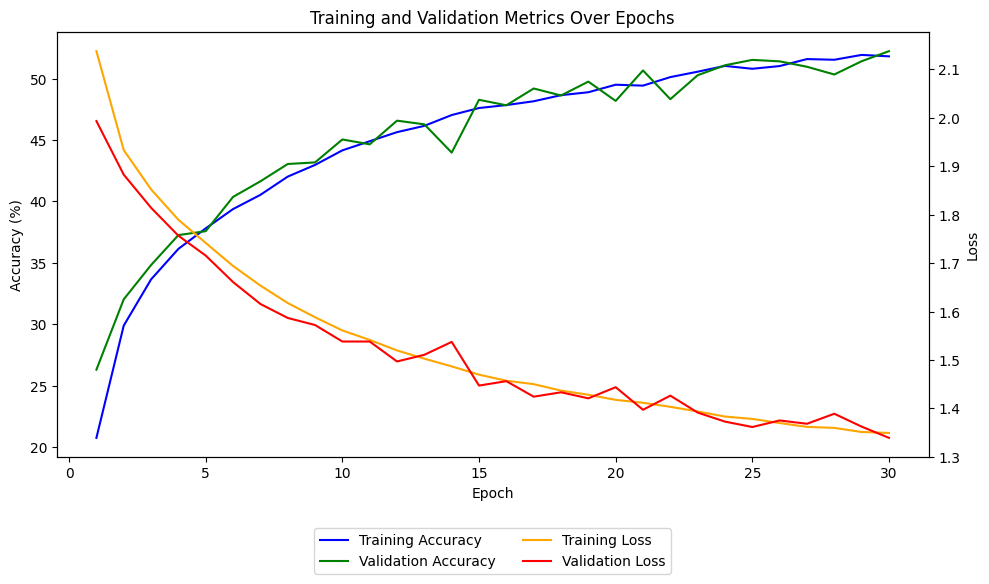

In [87]:
# Ensure necessary import
from IPython.display import clear_output

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 30
for epoch in range(epochs):
    # Training
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {epoch+1}") as train_bar:
        model.train()
        correct_train = 0
        total_train = 0
        total_loss_train = 0
        for batch, (X, y) in enumerate(train_dataloader):
            X = X.to(dev)
            y = y.to(dev)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_bar.update()

            # Accumulate training metrics
            total_loss_train += loss.item()
            correct_train += (pred.argmax(1) == y).type(torch.float).sum().item()
            total_train += y.size(0)

    avg_loss_train = total_loss_train / len(train_dataloader)
    accuracy_train = 100 * correct_train / total_train
    train_losses.append(avg_loss_train)
    train_accuracies.append(accuracy_train)

    # Validation
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {epoch+1}") as val_bar:
        model.eval()
        correct_val = 0
        total_val = 0
        total_loss_val = 0
        with torch.no_grad():
            for X_val, y_val in val_dataloader:
                X_val = X_val.to(dev)
                y_val = y_val.to(dev)
                pred_val = model(X_val)
                loss_val = loss_fn(pred_val, y_val)
                total_loss_val += loss_val.item()
                correct_val += (pred_val.argmax(1) == y_val).type(torch.float).sum().item()
                total_val += y_val.size(0)
                val_bar.update()

    avg_loss_val = total_loss_val / len(val_dataloader)
    accuracy_val = 100 * correct_val / total_val
    val_losses.append(avg_loss_val)
    val_accuracies.append(accuracy_val)

    # Print metrics
    print(f"Epoch {epoch+1}:")
    print(f"Training loss: {avg_loss_train:.3f}, accuracy: {accuracy_train:.2f}%")
    print(f"Validation loss: {avg_loss_val:.3f}, accuracy: {accuracy_val:.2f}%")

    # Plotting
    epochs_range = range(1, epoch + 2)  # +2 because epoch starts at 0 and we want to include current epoch

    # Clear previous plot output
    clear_output(wait=True)

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot accuracy on left y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color='black')
    acc_train_line, = ax1.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
    acc_val_line, = ax1.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a second y-axis for loss
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='black')
    loss_train_line, = ax2.plot(epochs_range, train_losses, label='Training Loss', color='orange')
    loss_val_line, = ax2.plot(epochs_range, val_losses, label='Validation Loss', color='red')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes
    lines = [acc_train_line, acc_val_line, loss_train_line, loss_val_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    plt.title('Training and Validation Metrics Over Epochs')
    plt.tight_layout()
    plt.show()


The final validation accuracy achieved after epoch 30 is approximately 56%, which beats the original model at 48%.



*   Increased the number of filters between the second and third convolution from 4 to 5, allowing for modeling of more complex features.
*   Increased the kernel and stride size in the initial/"stem" layer both from 1 to 2. This may aid the model in learning local spatial patterns from the start; reduce its susceptibility to noise; and combine simple features into slightly higher-level representations from the start. It also decreases the size of feature maps passed to subsequent layers, reducing computational requirements.
*   Reduced n_stages from 4 to 2, reducing the computational cost and retaining more of the input's spatial details. This relies on the CIFAR-10 dataset having a low resolution, as too many stages may over-compress the model to the point of unhelpfulness.
*   Increased blocks_per_stage from 2 to 3, allowing the model to learn more complex patterns at each stage. This partially offsets the effect of having fewer stages by allowing for higher abstraction in each stage.

